In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from IPython.display import Image

import boto3
import logging

boto3.set_stream_logger(name="botocore.credentials", level=logging.WARNING)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import json
import logging
import sys
from pathlib import Path

import ipytest

#CODE_FOLDER = Path("code")
#sys.path.extend([f"./{CODE_FOLDER}"])

#DATA_FILEPATH = "../data/penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

In [3]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [5]:
import boto3
import sagemaker
S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

print(region)

us-east-1


In [11]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['class'] = pd.Series(iris.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [13]:
col_names =  ['class'] + iris.feature_names
col_names

['class',
 'sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Reordering columns to make sure this works with Sagemaker XGBoost

In [15]:
iris_df = df[col_names]
iris_df.head()

,class,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    iris_df, test_size=0.33, random_state=2024, stratify=iris_df['class']
)

In [18]:
test_df['class'].value_counts()

class
0    17
2    17
1    16
Name: count, dtype: int64

In [20]:
train_df.to_csv('data/iris_train.csv', index=False, header=None)
test_df.to_csv('data/iris_test.csv', index=False, header=None)

In [21]:
infer_df = test_df.drop(['class'], axis=1)
infer_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
42,4.4,3.2,1.3,0.2
92,5.8,2.6,4.0,1.2
31,5.4,3.4,1.5,0.4
131,7.9,3.8,6.4,2.0
50,7.0,3.2,4.7,1.4


In [22]:
infer_df.to_csv('data/iris_infer.csv', index=False, header=None)

In [27]:
!aws s3 cp data/iris_infer.csv s3://beercafe-ml-bucket/sagemaker-course/iris/batch_transform/

Completed 850 Bytes/850 Bytes (415 Bytes/s) with 1 file(s) remaining
upload: data\iris_infer.csv to s3://beercafe-ml-bucket/sagemaker-course/iris/batch_transform/iris_infer.csv


In [24]:
!aws s3 cp data/iris_train.csv s3://beercafe-ml-bucket/sagemaker-course/iris/data/

Completed 1.9 KiB/1.9 KiB (776 Bytes/s) with 1 file(s) remaining
upload: data\iris_train.csv to s3://beercafe-ml-bucket/sagemaker-course/iris/data/iris_train.csv


In [25]:
!aws s3 cp data/iris_test.csv s3://beercafe-ml-bucket/sagemaker-course/iris/data/

Completed 950 Bytes/950 Bytes (386 Bytes/s) with 1 file(s) remaining
upload: data\iris_test.csv to s3://beercafe-ml-bucket/sagemaker-course/iris/data/iris_test.csv


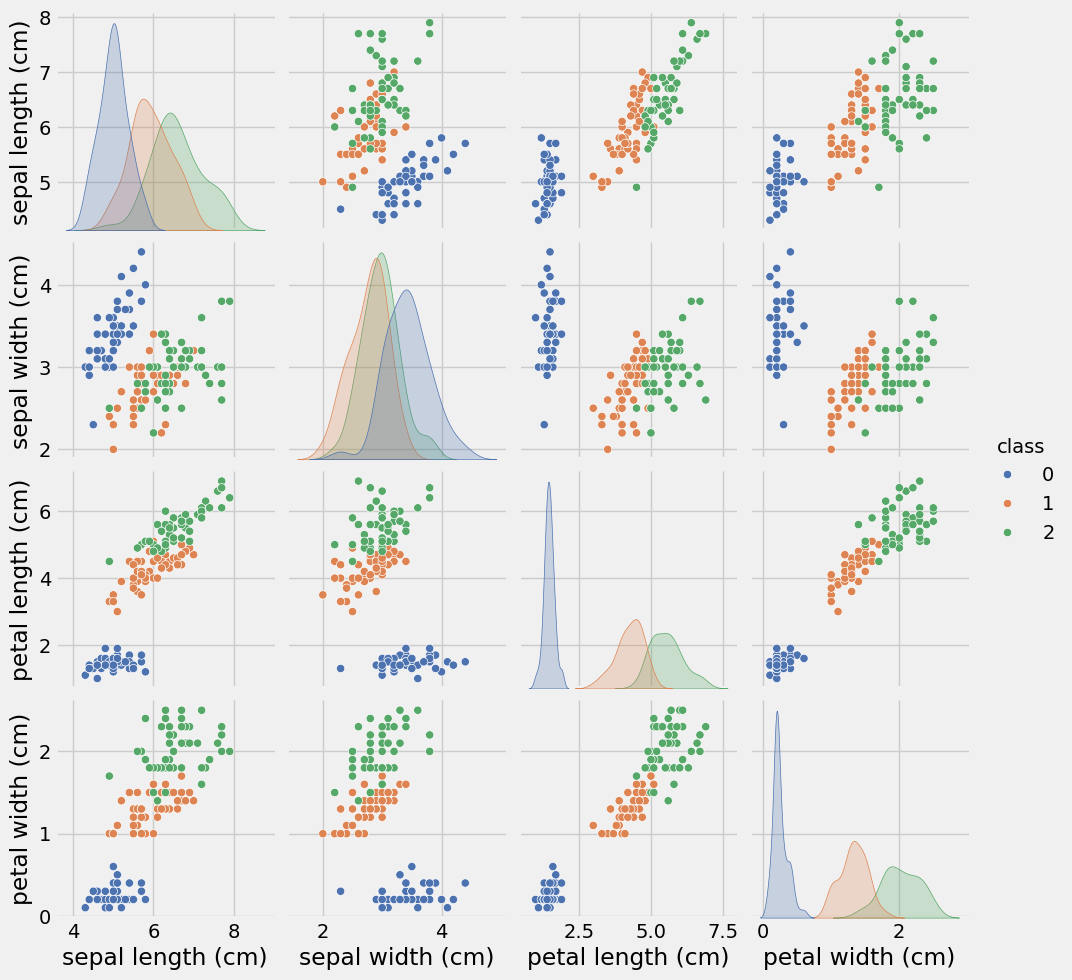

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

sns.pairplot(iris_df, hue="class", palette="deep")